In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

## Merging live projects with ended projects

### Live projects

In [2]:
df_live = pd.read_csv('live.csv', encoding='cp1252', index_col=0)
df_live.info()

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11,14,17,18,19,24,32,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 88384 entries, 0 to 88383
Data columns (total 40 columns):
backers_count               88384 non-null int64
blurb                       88384 non-null object
category                    88384 non-null object
converted_pledged_amount    3591 non-null float64
country                     88384 non-null object
created_at                  88384 non-null int64
creator                     88384 non-null object
currency                    88384 non-null object
currency_symbol             88384 non-null object
currency_trailing_code      88384 non-null bool
current_currency            3591 non-null object
deadline                    88384 non-null int64
disable_communication       88384 non-null bool
friends                     1719 non-null object
goal                        88384 non-null float64
id                          88384 non-null int64
is_backing                  1719 non-null object
is_starrable                10652 non-null object
i

### Ended projects

In [3]:
df_ended = pd.read_csv('ended.csv', encoding='cp1252', index_col=0)
df_ended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56874 entries, 0 to 56873
Data columns (total 40 columns):
backers_count               56874 non-null int64
blurb                       56872 non-null object
category                    56874 non-null object
converted_pledged_amount    1464 non-null float64
country                     56874 non-null object
created_at                  56874 non-null int64
creator                     56874 non-null object
currency                    56874 non-null object
currency_symbol             56874 non-null object
currency_trailing_code      56874 non-null bool
current_currency            1464 non-null object
deadline                    56874 non-null int64
disable_communication       56874 non-null bool
friends                     3 non-null object
goal                        56874 non-null float64
id                          56874 non-null int64
is_backing                  3 non-null object
is_starrable                4699 non-null object
is_starr

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11,14,17,18,19,24,32,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# rename columns
df_ended.rename(columns=lambda name: name+'_end', inplace=True)

In [5]:
# merge projects to single dataframe
df_projects = df_live.merge(df_ended, left_on='id', right_on='id_end')
df_projects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 80 columns):
backers_count                   65038 non-null int64
blurb                           65038 non-null object
category                        65038 non-null object
converted_pledged_amount        0 non-null float64
country                         65038 non-null object
created_at                      65038 non-null int64
creator                         65038 non-null object
currency                        65038 non-null object
currency_symbol                 65038 non-null object
currency_trailing_code          65038 non-null bool
current_currency                0 non-null object
deadline                        65038 non-null int64
disable_communication           65038 non-null bool
friends                         904 non-null object
goal                            65038 non-null float64
id                              65038 non-null int64
is_backing                      904 non-nul

### Cleaning merged dataset

In [6]:
# drop duplicate columns
cols_to_drop = []
for col in df_live.columns:
    try:
        (df_projects[col] != df_projects[col+'_end']).value_counts()[True]
    except KeyError:
        cols_to_drop.append(col+'_end')
print(cols_to_drop)
df_projects.drop(cols_to_drop, axis=1, inplace=True)

['country_end', 'created_at_end', 'currency_end', 'currency_symbol_end', 'currency_trailing_code_end', 'goal_end', 'id_end', 'slug_end']


In [7]:
# drop columns with less than 50% of values
df_projects.dropna(axis=1, thresh=df_projects.shape[0]/2, inplace=True)

In [8]:
df_projects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 50 columns):
backers_count                65038 non-null int64
blurb                        65038 non-null object
category                     65038 non-null object
country                      65038 non-null object
created_at                   65038 non-null int64
creator                      65038 non-null object
currency                     65038 non-null object
currency_symbol              65038 non-null object
currency_trailing_code       65038 non-null bool
deadline                     65038 non-null int64
disable_communication        65038 non-null bool
goal                         65038 non-null float64
id                           65038 non-null int64
launched_at                  65038 non-null int64
location                     65038 non-null object
name                         65038 non-null object
photo                        65038 non-null object
pledged                      650

### Resolving inconsistency

#### launched_at

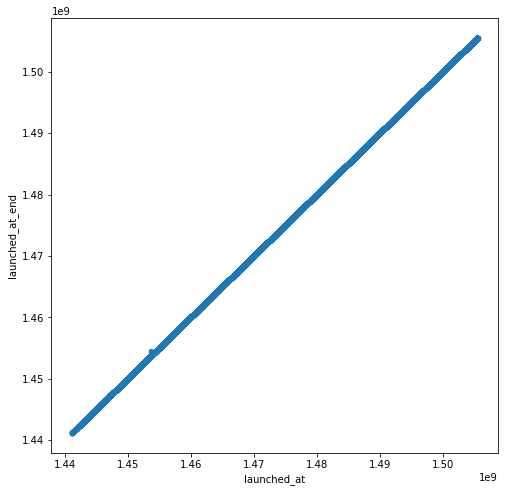

In [11]:
df_projects.plot(x='launched_at', y='launched_at_end', kind='scatter', figsize=(8,8))

In [12]:
# this should not contain True, but it does => inconsistency in dataset
(df_projects['launched_at'] != df_projects['launched_at_end']).value_counts()

False    65037
True         1
dtype: int64

In [13]:
# look at values
df_projects[(df_projects['launched_at'] != df_projects['launched_at_end'])][['id','name','launched_at','launched_at_end']]

,id,name,launched_at,launched_at_end
9271,615482414,"Instant Hydrator, Hydrates,All Natural, Digest...",1453784664,1454537838


In [14]:
# first value is incorrect, drop first column
# https://www.kickstarter.com/projects/1428469449/instant-hydrator-hydratesall-natural-digestive-ph
df_projects.drop('launched_at', axis=1, inplace=True)

#### deadline

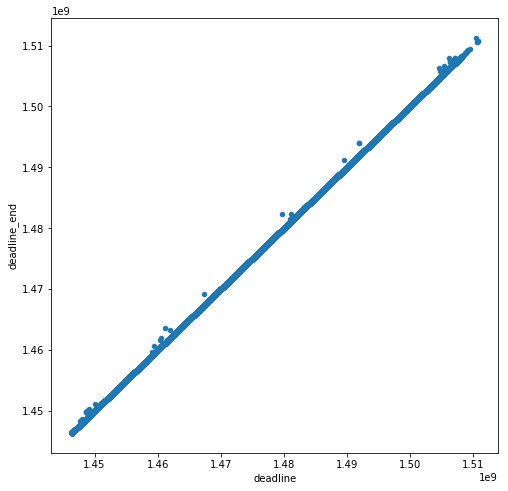

In [15]:
df_projects.plot(x='deadline', y='deadline_end', kind='scatter', figsize=(8,8))

In [16]:
# this should not contain True, but it does => inconsistency in dataset
(df_projects['deadline'] != df_projects['deadline_end']).value_counts()

False    64980
True        58
dtype: int64

In [17]:
# look at values
df_projects[(df_projects['deadline'] != df_projects['deadline_end'])][['id','name','deadline','deadline_end']].head(10)

,id,name,deadline,deadline_end
619,603503453,"The Monsieur Barbier Box : Shaving & Music, Ra...",1448922180,1449613380
633,1495917692,2016 Letterpress Calendar . The creative manif...,1449009780,1449441780
1345,1378352264,Casablancas | The Man Who Loved Women,1449164045,1450287245
1366,1866394158,I Love Therefore I Am - Documentary,1448866800,1449730800
1780,1020745465,SECOND CHANCE - DEUXI?ME CHANCE,1450016445,1451226045
2110,2044197681,Welcome to Another World!,1448018810,1448623610
2284,281156070,Würm : a prehistoric RPG,1449239761,1449671761
2381,174456433,Pur cashmere poncho Workshop,1448756490,1449966090
2415,382060495,Pankapu: the Dreamkeeper,1448621976,1449831576
2487,1401246575,#lanouvelleolympe,1448630040,1449839640


In [18]:
# first values are incorrect again, drop first column
df_projects.drop('deadline', axis=1, inplace=True)

In [19]:
df_projects.to_csv('projects.csv')

## Analysing dataset

In [73]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [41]:
# seaborn causes bugs in pyplot (e.g. hiding outliers in boxplot)
import seaborn as sns

In [21]:
# set default figsize
plt.rcParams['figure.figsize'] = [15, 6]

In [22]:
df_projects = pd.read_csv('projects.csv', encoding='cp1252', index_col=0)
df_projects.head()

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,backers_count,blurb,category,country,created_at,creator,currency,currency_symbol,currency_trailing_code,disable_communication,...,profile_end,scraped_at_end,source_url_end,spotlight_end,staff_pick_end,state_end,state_changed_at_end,static_usd_rate_end,urls_end,usd_pledged_end
0,22,Help SCDT fund their inaugural performance in ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1444460998,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,False,...,"{""background_image_opacity"":0.8,""link_text_col...",1.450359e+09,https://www.kickstarter.com/discover/categorie...,True,NaN,successful,1448092740,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",8441.0
1,0,This is where inspired dancers from all ages g...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",NL,1444938006,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",EUR,€,False,False,...,"{""background_image_opacity"":0.8,""link_text_col...",1.450359e+09,https://www.kickstarter.com/discover/categorie...,False,NaN,failed,1447975466,1.136392,"{""web"":{""project"":""https://www.kickstarter.com...",0.0
2,1,In our 8th year of equipping students to give ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1444906983,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,False,...,"{""background_image_opacity"":0.8,""link_text_col...",1.450359e+09,https://www.kickstarter.com/discover/categorie...,False,NaN,failed,1448326800,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",70.0
3,1,Verve Collisionz is a hip hop group at the Uni...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1444919408,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,False,...,"{""background_image_opacity"":0.8,""link_text_col...",1.453982e+09,https://www.kickstarter.com/discover/categorie...,True,False,successful,1450814542,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",904.0
4,5,Verve Collisionz is a hip hop group at the Uni...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1444919408,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,False,...,"{""background_image_opacity"":0.8,""link_text_col...",1.453982e+09,https://www.kickstarter.com/discover/categorie...,True,False,successful,1450814542,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",904.0


In [23]:
df_projects.describe()

,backers_count,created_at,goal,id,pledged,scraped_at,state_changed_at,static_usd_rate,usd_pledged,backers_count_end,deadline_end,launched_at_end,pledged_end,scraped_at_end,state_changed_at_end,static_usd_rate_end,usd_pledged_end
count,65038.000000,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,65038.000000,6.503800e+04,65038.000000,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,65038.000000,6.503800e+04
mean,93.181801,1.467838e+09,7.045290e+04,1.073002e+09,9.706526e+03,1.474094e+09,1.472475e+09,0.994714,8.547335e+03,159.475753,1.475652e+09,1.472475e+09,1.708096e+04,1.477562e+09,1.475610e+09,0.994716,1.502729e+04
std,924.687360,2.076627e+07,1.474647e+06,6.193397e+08,8.741706e+04,1.669881e+07,1.677239e+07,0.220278,8.302131e+04,1272.604621,1.672703e+07,1.677237e+07,1.353804e+05,1.639163e+07,1.672708e+07,0.220277,1.264395e+05
min,0.000000,1.266343e+09,1.000000e+00,1.852000e+04,0.000000e+00,1.446387e+09,1.441143e+09,0.009143,0.000000e+00,0.000000,1.446392e+09,1.441143e+09,0.000000e+00,1.450359e+09,1.446392e+09,0.009143,0.000000e+00
25%,1.000000,1.455334e+09,2.400000e+03,5.376639e+08,1.200000e+01,1.460689e+09,1.458759e+09,1.000000,1.200000e+01,2.000000,1.462058e+09,1.458759e+09,3.100000e+01,1.463290e+09,1.462036e+09,1.000000,3.093878e+01
50%,7.000000,1.467867e+09,7.000000e+03,1.072097e+09,3.860000e+02,1.473914e+09,1.471891e+09,1.000000,3.700000e+02,13.000000,1.475073e+09,1.471891e+09,7.510000e+02,1.476502e+09,1.474991e+09,1.000000,7.187814e+02
75%,41.000000,1.483904e+09,2.000000e+04,1.606240e+09,2.982000e+03,1.487227e+09,1.486687e+09,1.000000,2.778168e+03,75.000000,1.489795e+09,1.486687e+09,5.891750e+03,1.492298e+09,1.489787e+09,1.000000,5.563885e+03
max,145232.000000,1.505473e+09,1.000000e+08,2.147422e+09,1.102400e+07,1.505539e+09,1.505523e+09,1.557361,1.102400e+07,154926.000000,1.511283e+09,1.505523e+09,1.277984e+07,1.508088e+09,1.508084e+09,1.557361,1.277984e+07


In [24]:
df_projects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 48 columns):
backers_count                65038 non-null int64
blurb                        65038 non-null object
category                     65038 non-null object
country                      65038 non-null object
created_at                   65038 non-null int64
creator                      65038 non-null object
currency                     65038 non-null object
currency_symbol              65038 non-null object
currency_trailing_code       65038 non-null bool
disable_communication        65038 non-null bool
goal                         65038 non-null float64
id                           65038 non-null int64
location                     65038 non-null object
name                         65038 non-null object
photo                        65038 non-null object
pledged                      65038 non-null float64
profile                      65038 non-null object
scraped_at                   

### Numeric variables

In [25]:
selected_cols = ['backers_count', 'goal', 'pledged', 'usd_pledged', 'backers_count_end', 'pledged_end', 'usd_pledged_end', 'state_end']
df_projects[selected_cols].head()

,backers_count,goal,pledged,usd_pledged,backers_count_end,pledged_end,usd_pledged_end,state_end
0,22,8000.0,1272.0,1272.0,87,8441.0,8441.0,successful
1,0,500.0,0.0,0.0,0,0.0,0.0,failed
2,1,25000.0,50.0,50.0,3,70.0,70.0,failed
3,1,600.0,30.0,30.0,22,904.0,904.0,successful
4,5,600.0,306.0,306.0,22,904.0,904.0,successful


In [26]:
df_projects[selected_cols].describe()

,backers_count,goal,pledged,usd_pledged,backers_count_end,pledged_end,usd_pledged_end
count,65038.000000,6.503800e+04,6.503800e+04,6.503800e+04,65038.000000,6.503800e+04,6.503800e+04
mean,93.181801,7.045290e+04,9.706526e+03,8.547335e+03,159.475753,1.708096e+04,1.502729e+04
std,924.687360,1.474647e+06,8.741706e+04,8.302131e+04,1272.604621,1.353804e+05,1.264395e+05
min,0.000000,1.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1.000000,2.400000e+03,1.200000e+01,1.200000e+01,2.000000,3.100000e+01,3.093878e+01
50%,7.000000,7.000000e+03,3.860000e+02,3.700000e+02,13.000000,7.510000e+02,7.187814e+02
75%,41.000000,2.000000e+04,2.982000e+03,2.778168e+03,75.000000,5.891750e+03,5.563885e+03
max,145232.000000,1.000000e+08,1.102400e+07,1.102400e+07,154926.000000,1.277984e+07,1.277984e+07


In [ ]:
figure = sns.pairplot(df_projects[selected_cols], hue='state_end')

In [ ]:
figure.savefig('figure.png', format='png', dpi=200)

#### backers_count

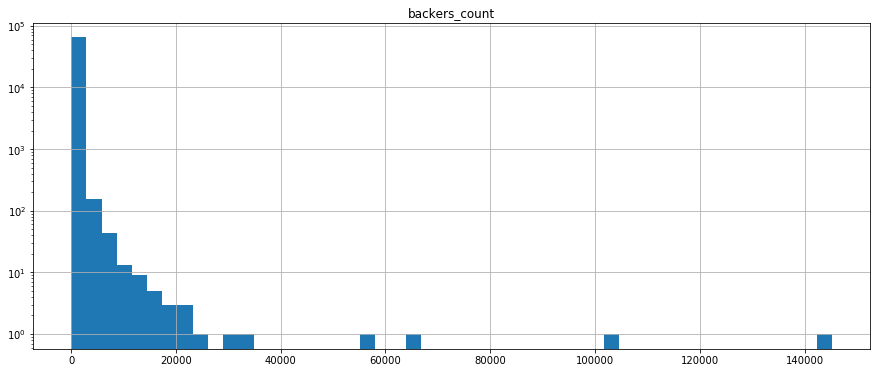

In [27]:
df_projects.hist(column='backers_count', bins=50)
plt.yscale('log')

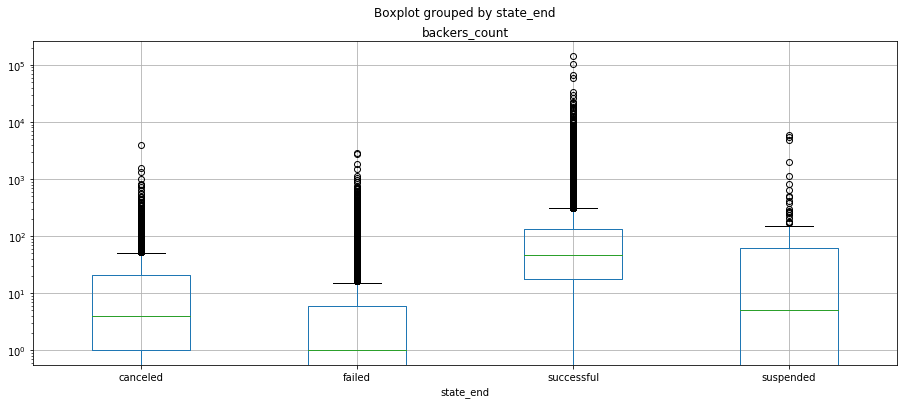

In [28]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

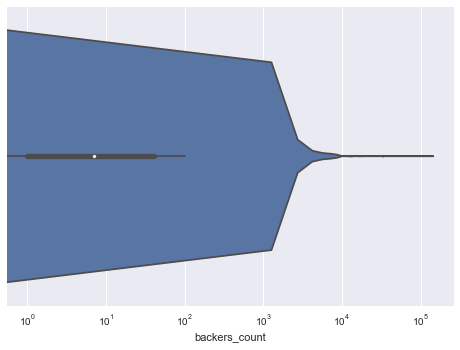

In [42]:
sns.violinplot(df_projects['backers_count'], width=20)
plt.xscale('log')

#### goal

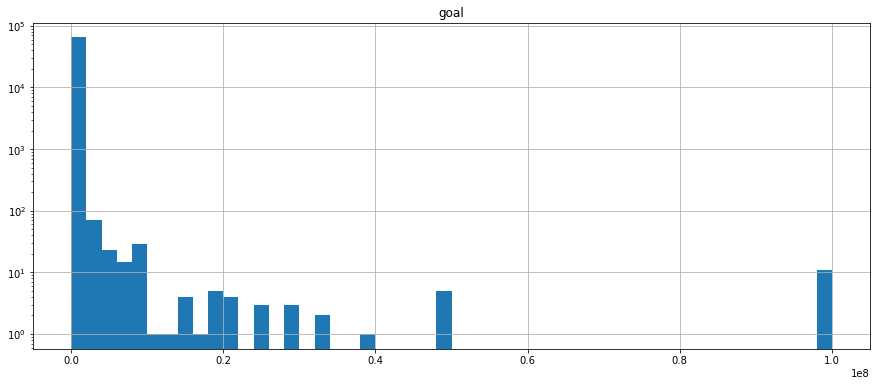

In [29]:
df_projects.hist(column='goal', bins=50)
plt.yscale('log')

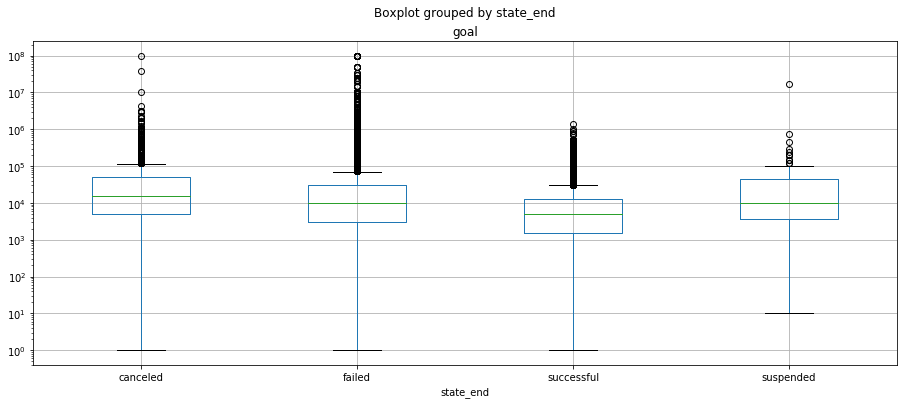

In [30]:
bp = df_projects.boxplot(column='goal', by='state_end')
plt.yscale('log')

#### pledged

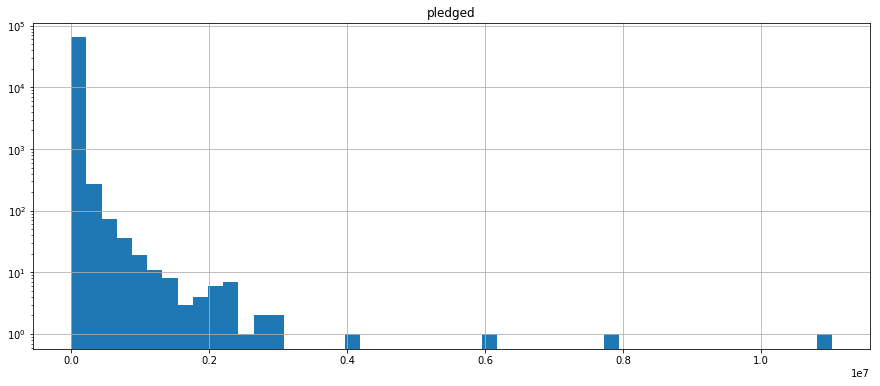

In [31]:
df_projects.hist(column='pledged', bins=50)
plt.yscale('log')

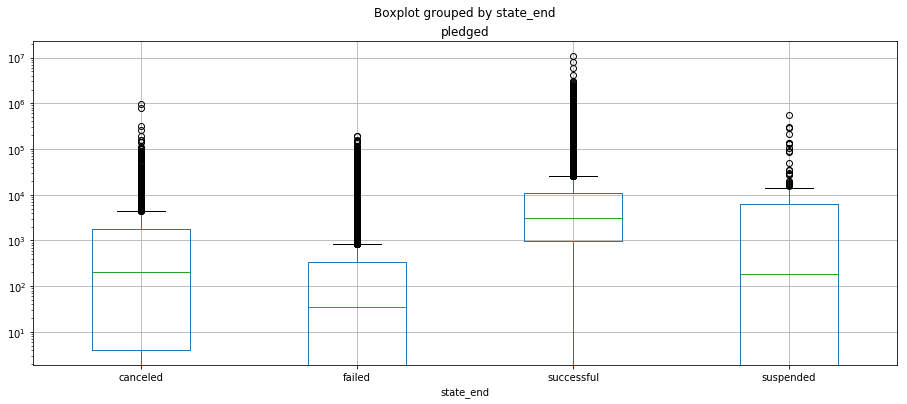

In [32]:
bp = df_projects.boxplot(column='pledged', by='state_end')
plt.yscale('log')

#### usd_pledged

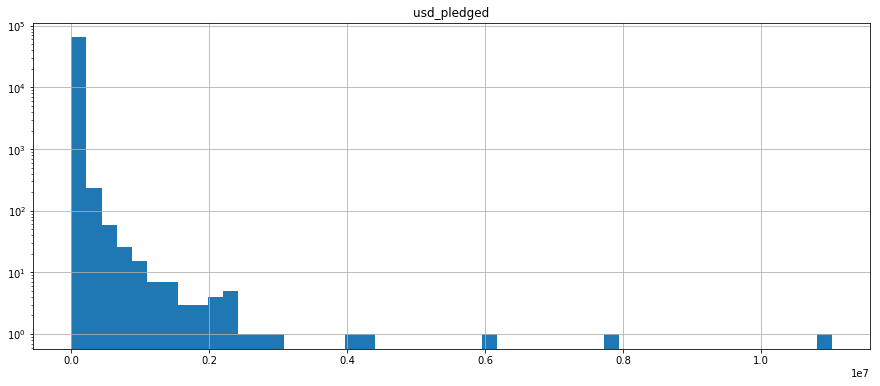

In [33]:
df_projects.hist(column='usd_pledged', bins=50)
plt.yscale('log')

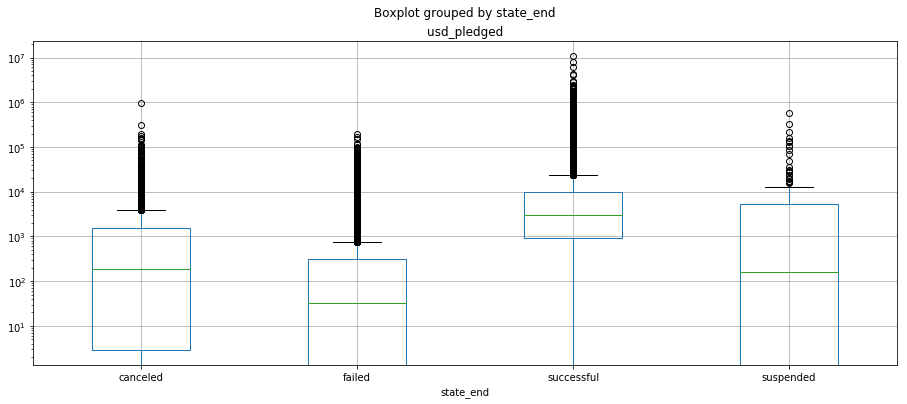

In [34]:
bp = df_projects.boxplot(column='usd_pledged', by='state_end')
plt.yscale('log')

#### backers_count_end

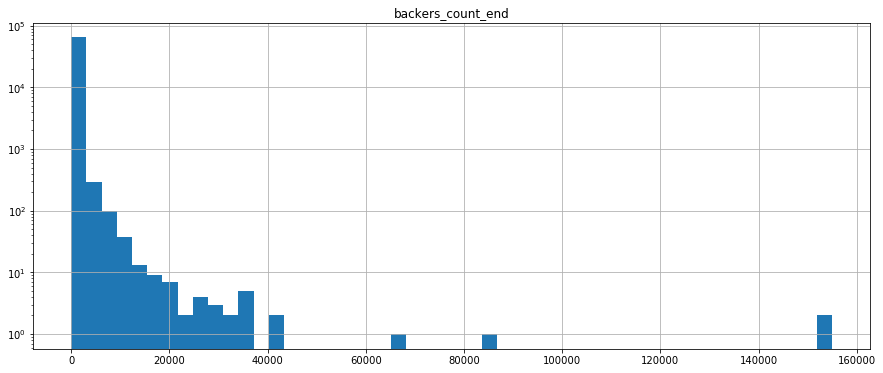

In [35]:
df_projects.hist(column='backers_count_end', bins=50)
plt.yscale('log')

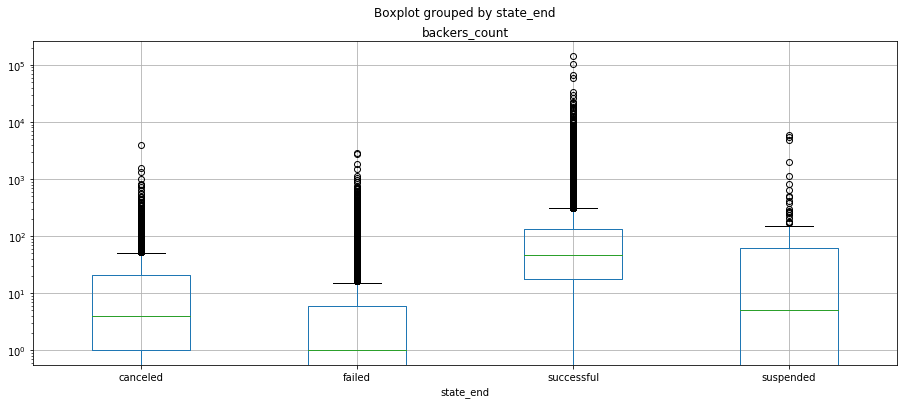

In [36]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

#### pledged_end

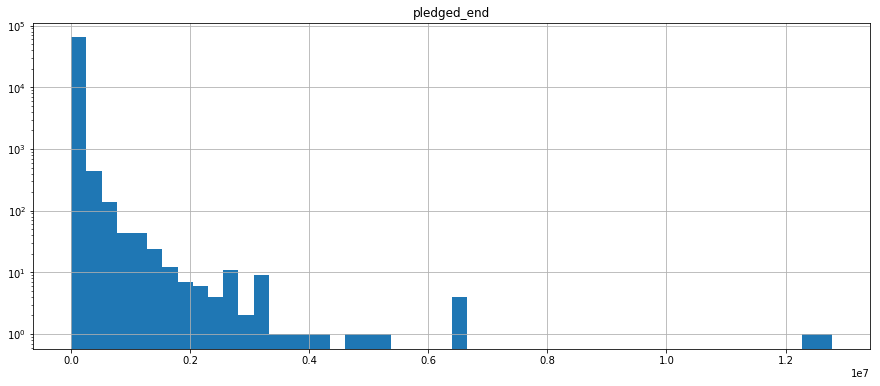

In [37]:
df_projects.hist(column='pledged_end', bins=50)
plt.yscale('log')

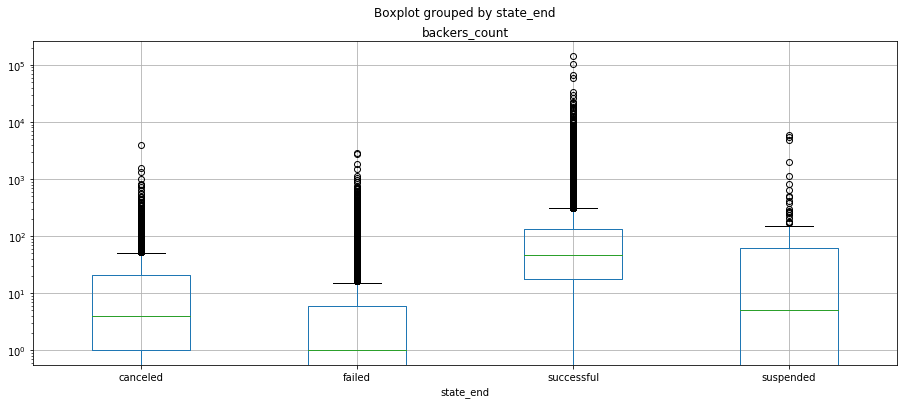

In [38]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

#### usd_pledged_end

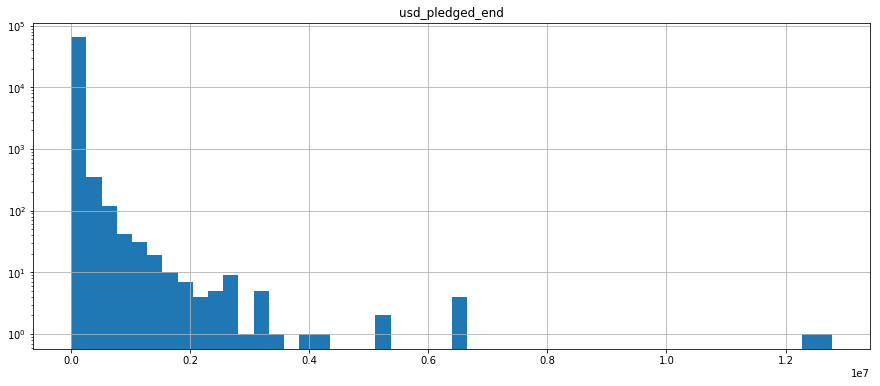

In [39]:
df_projects.hist(column='usd_pledged_end', bins=50)
plt.yscale('log')

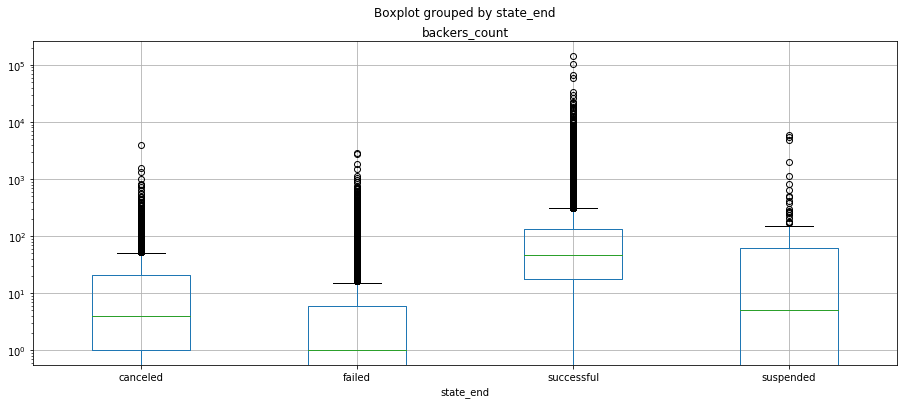

In [40]:
bp = df_projects.boxplot(column='backers_count', by='state_end')
plt.yscale('log')

In [71]:
def print_corr_heatmap(cols):
    corr = df_projects[cols].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(corr, mask=mask, annot=True, square=True)

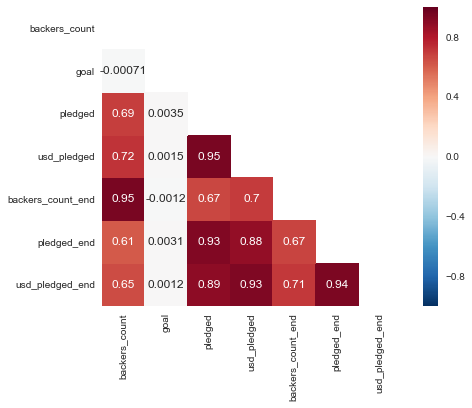

In [44]:
print_corr_heatmap(selected_cols)

All of seven variables have similar **long tale distribution**. Also pledged and usd_pledged equivalents are very similar which suggests that most of projects collected their money in USD. Let's look at categorical variables to find out.

### Categorical variables

In [45]:
df_projects = pd.read_csv('projects.csv', encoding='cp1252', index_col=0)

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [46]:
selected_cols = [
    'state_end',
    'currency_trailing_code',
    'disable_communication',
    'state',
    'spotlight',
    'disable_communication_end',
    'spotlight_end',
    'staff_pick',
    'staff_pick_end',
    'country',
    'currency',
    'currency_symbol'
]

In [47]:
df_projects[selected_cols].head()

,state_end,currency_trailing_code,disable_communication,state,spotlight,disable_communication_end,spotlight_end,staff_pick,staff_pick_end,country,currency,currency_symbol
0,successful,True,False,live,False,False,True,NaN,NaN,US,USD,$
1,failed,False,False,live,False,False,False,NaN,NaN,NL,EUR,€
2,failed,True,False,live,False,False,False,NaN,NaN,US,USD,$
3,successful,True,False,live,False,False,True,NaN,False,US,USD,$
4,successful,True,False,live,False,False,True,NaN,False,US,USD,$


In [48]:
def print_counts(cols):
    for col in cols:
        print('\n>>> '+col+':')
        print(df_projects[col].value_counts())

In [49]:
print_counts(selected_cols)


>>> state_end:
failed        36190
successful    26342
canceled       2380
suspended       126
Name: state_end, dtype: int64

>>> currency_trailing_code:
True     51119
False    13919
Name: currency_trailing_code, dtype: int64

>>> disable_communication:
False    65038
Name: disable_communication, dtype: int64

>>> state:
live    65038
Name: state, dtype: int64

>>> spotlight:
False    65038
Name: spotlight, dtype: int64

>>> disable_communication_end:
False    64912
True       126
Name: disable_communication_end, dtype: int64

>>> spotlight_end:
False    38696
True     26342
Name: spotlight_end, dtype: int64

>>> staff_pick:
False    52537
True      4966
Name: staff_pick, dtype: int64

>>> staff_pick_end:
False    55199
True      6150
Name: staff_pick_end, dtype: int64

>>> country:
US    43245
GB     6757
CA     3296
AU     1814
DE     1598
IT     1362
FR     1291
ES     1018
MX      854
NL      649
SE      569
CH      373
DK      330
BE      329
NZ      317
IE      265
AT      253


#### Dropping columns

In [50]:
# 'disable_communication' is always false
# 'state' is always live
# 'spotlight' is always false
# 'currency_symbol' carries the same information as currency and some values are not recognizable
remove_cols = ['disable_communication','state','spotlight','currency_symbol']
df_projects.drop(remove_cols, axis=1, inplace=True)

In [51]:
for col in remove_cols:
    selected_cols.remove(col)

In [52]:
print_counts(selected_cols[:-2])


>>> state_end:
failed        36190
successful    26342
canceled       2380
suspended       126
Name: state_end, dtype: int64

>>> currency_trailing_code:
True     51119
False    13919
Name: currency_trailing_code, dtype: int64

>>> disable_communication_end:
False    64912
True       126
Name: disable_communication_end, dtype: int64

>>> spotlight_end:
False    38696
True     26342
Name: spotlight_end, dtype: int64

>>> staff_pick:
False    52537
True      4966
Name: staff_pick, dtype: int64

>>> staff_pick_end:
False    55199
True      6150
Name: staff_pick_end, dtype: int64


#### Handling missing values

In [53]:
df_projects[selected_cols].isnull().sum()

state_end                       0
currency_trailing_code          0
disable_communication_end       0
spotlight_end                   0
staff_pick                   7535
staff_pick_end               3689
country                         0
currency                        0
dtype: int64

In [54]:
# https://www.kickstarter.com/blog/introducing-projects-we-love-badges
# 'staff_pick' means 'has_badge' (projects we love)
# badges were added on Feb 2 2016
import time
timestamp = time.mktime(datetime.strptime('3/2/2016', "%d/%m/%Y").timetuple())
timestamp

1454454000.0

In [55]:
df_projects[df_projects['scraped_at']<timestamp]['staff_pick'].isnull().sum()

7535

In [56]:
df_projects[df_projects['scraped_at_end']<timestamp]['staff_pick_end'].isnull().sum()

3689

In [57]:
# values are missing due to the fact that badges did not exist before certain period
# therefore we can insert False to fill them
df_projects.loc[df_projects['staff_pick'].isnull(), 'staff_pick'] = False
df_projects.loc[df_projects['staff_pick_end'].isnull(), 'staff_pick_end'] = False
df_projects[selected_cols].isnull().sum()

state_end                    0
currency_trailing_code       0
disable_communication_end    0
spotlight_end                0
staff_pick                   0
staff_pick_end               0
country                      0
currency                     0
dtype: int64

In [58]:
print_counts(selected_cols[:-2])


>>> state_end:
failed        36190
successful    26342
canceled       2380
suspended       126
Name: state_end, dtype: int64

>>> currency_trailing_code:
True     51119
False    13919
Name: currency_trailing_code, dtype: int64

>>> disable_communication_end:
False    64912
True       126
Name: disable_communication_end, dtype: int64

>>> spotlight_end:
False    38696
True     26342
Name: spotlight_end, dtype: int64

>>> staff_pick:
False    60072
True      4966
Name: staff_pick, dtype: int64

>>> staff_pick_end:
False    58888
True      6150
Name: staff_pick_end, dtype: int64


#### Updating dtypes

In [59]:
df_projects[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 8 columns):
state_end                    65038 non-null object
currency_trailing_code       65038 non-null bool
disable_communication_end    65038 non-null bool
spotlight_end                65038 non-null bool
staff_pick                   65038 non-null object
staff_pick_end               65038 non-null object
country                      65038 non-null object
currency                     65038 non-null object
dtypes: bool(3), object(5)
memory usage: 3.2+ MB


In [60]:
for col in selected_cols[1:-2]:
    df_projects[col] = df_projects[col].astype('bool')
df_projects[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 8 columns):
state_end                    65038 non-null object
currency_trailing_code       65038 non-null bool
disable_communication_end    65038 non-null bool
spotlight_end                65038 non-null bool
staff_pick                   65038 non-null bool
staff_pick_end               65038 non-null bool
country                      65038 non-null object
currency                     65038 non-null object
dtypes: bool(5), object(3)
memory usage: 2.3+ MB


#### Discovering correlations

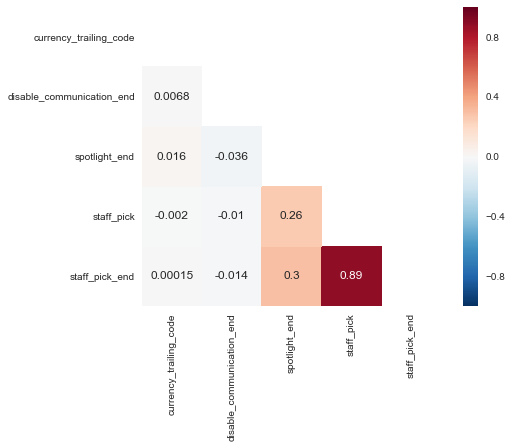

In [61]:
print_corr_heatmap(selected_cols[1:-2])

In [62]:
# https://www.theguardian.com/technology/2015/mar/25/kickstarter-spotlight-crowdfunding-successful-projects
# 'spotlight_end' basicaly means 'is_successfull'
# proof:
df_projects[(df_projects['spotlight_end']==True)].equals(df_projects[df_projects['state_end']=='successful'])

True

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028B893357B8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000028B8917EEB8>]], dtype=object)

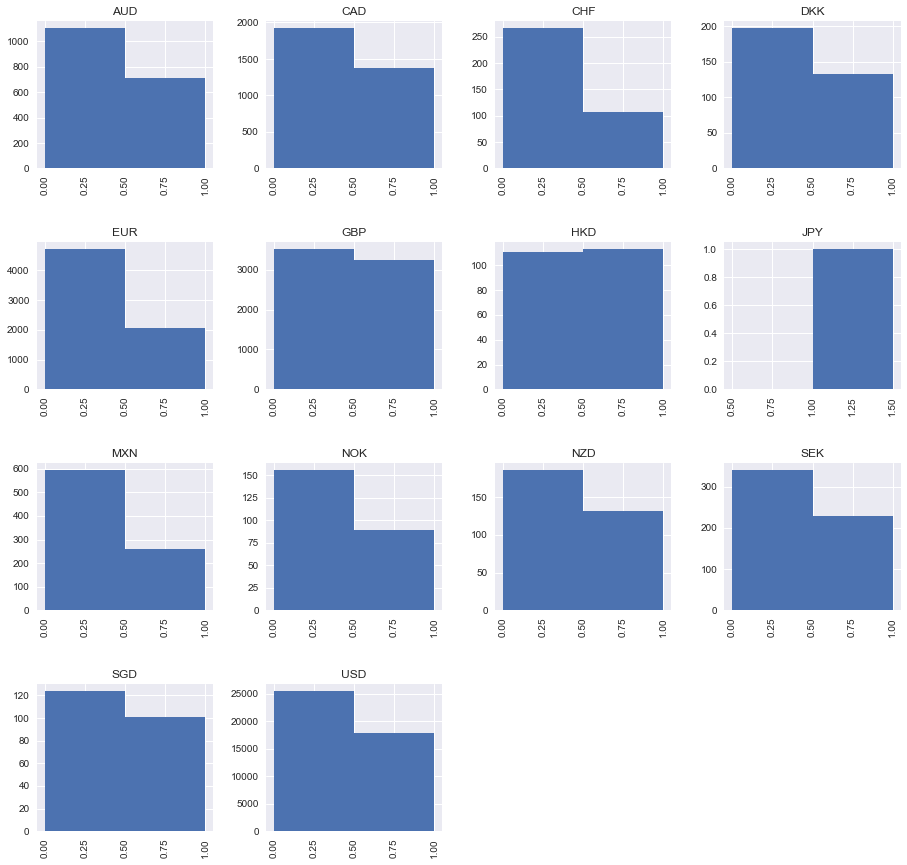

In [63]:
df_projects.hist(column='spotlight_end', bins=2, by='currency', figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028BE5F15160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000028BE7E1C630>]], dtype=object)

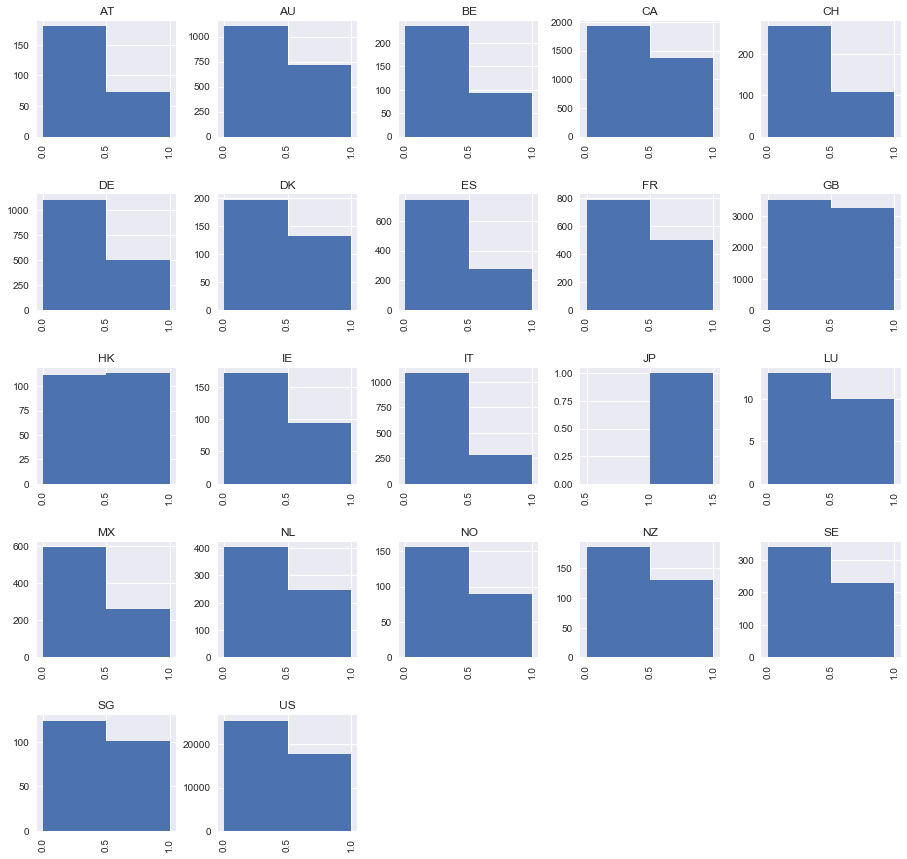

In [64]:
df_projects.hist(column='spotlight_end', bins=2, by='country', figsize=(15, 15))

As we can see, there is a difference in success rate of projects created in different countries or projects collecting money in different currencies. It will probably be helpfull to calculate these success rates for each category.

In [65]:
df_projects.to_csv('projects_acv.csv')

In [5]:
df_projects = pd.read_csv('projects_acv.csv', index_col=0, encoding='cp1252')

### Timestamps

In [142]:
selected_cols = [
    'created_at',
    'launched_at_end',
    'state_changed_at',
    'deadline_end',
    'state_changed_at_end',
    'scraped_at',
    'scraped_at_end',
]

In [7]:
df_projects[selected_cols].head()

,created_at,scraped_at,state_changed_at,deadline_end,scraped_at_end,state_changed_at_end,launched_at_end
0,1444460998,1.446387e+09,1445121152,1448092740,1.450359e+09,1448092740,1445121152
1,1444938006,1.446387e+09,1445379866,1447975466,1.450359e+09,1447975466,1445379866
2,1444906983,1.446387e+09,1445762846,1448326800,1.450359e+09,1448326800,1445762846
3,1444919408,1.446387e+09,1445626939,1450814539,1.453982e+09,1450814542,1445626939
4,1444919408,1.450359e+09,1445626939,1450814539,1.453982e+09,1450814542,1445626939


In [8]:
# no missing values
df_projects[selected_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65038 entries, 0 to 65037
Data columns (total 7 columns):
created_at              65038 non-null int64
scraped_at              65038 non-null float64
state_changed_at        65038 non-null int64
deadline_end            65038 non-null int64
scraped_at_end          65038 non-null float64
state_changed_at_end    65038 non-null int64
launched_at_end         65038 non-null int64
dtypes: float64(2), int64(5)
memory usage: 4.0 MB


In [9]:
df_projects[selected_cols].describe()

,created_at,scraped_at,state_changed_at,deadline_end,scraped_at_end,state_changed_at_end,launched_at_end
count,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04,6.503800e+04
mean,1.467838e+09,1.474094e+09,1.472475e+09,1.475652e+09,1.477562e+09,1.475610e+09,1.472475e+09
std,2.076627e+07,1.669881e+07,1.677239e+07,1.672703e+07,1.639163e+07,1.672708e+07,1.677237e+07
min,1.266343e+09,1.446387e+09,1.441143e+09,1.446392e+09,1.450359e+09,1.446392e+09,1.441143e+09
25%,1.455334e+09,1.460689e+09,1.458759e+09,1.462058e+09,1.463290e+09,1.462036e+09,1.458759e+09
50%,1.467867e+09,1.473914e+09,1.471891e+09,1.475073e+09,1.476502e+09,1.474991e+09,1.471891e+09
75%,1.483904e+09,1.487227e+09,1.486687e+09,1.489795e+09,1.492298e+09,1.489787e+09,1.486687e+09
max,1.505473e+09,1.505539e+09,1.505523e+09,1.511283e+09,1.508088e+09,1.508084e+09,1.505523e+09


#### Distribution

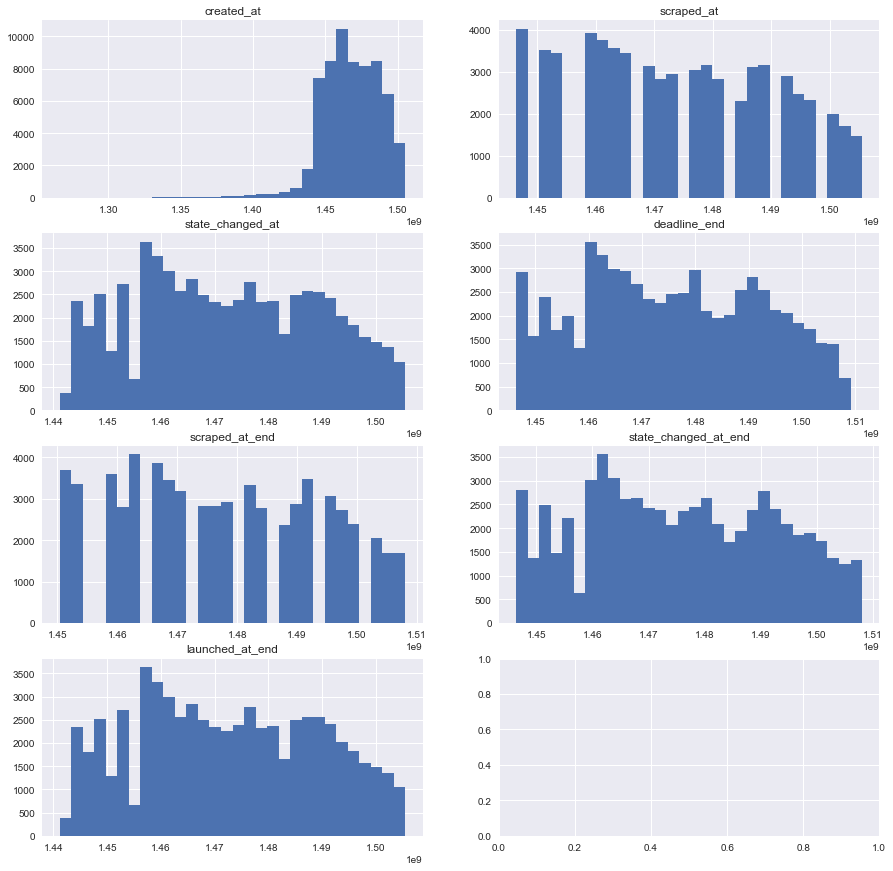

In [56]:
fig, ax = plt.subplots(nrows=4, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(7):
    plt.subplot(4, 2, i+1, title=selected_cols[i])
    plt.hist(df_projects[selected_cols[i]], bins=30)

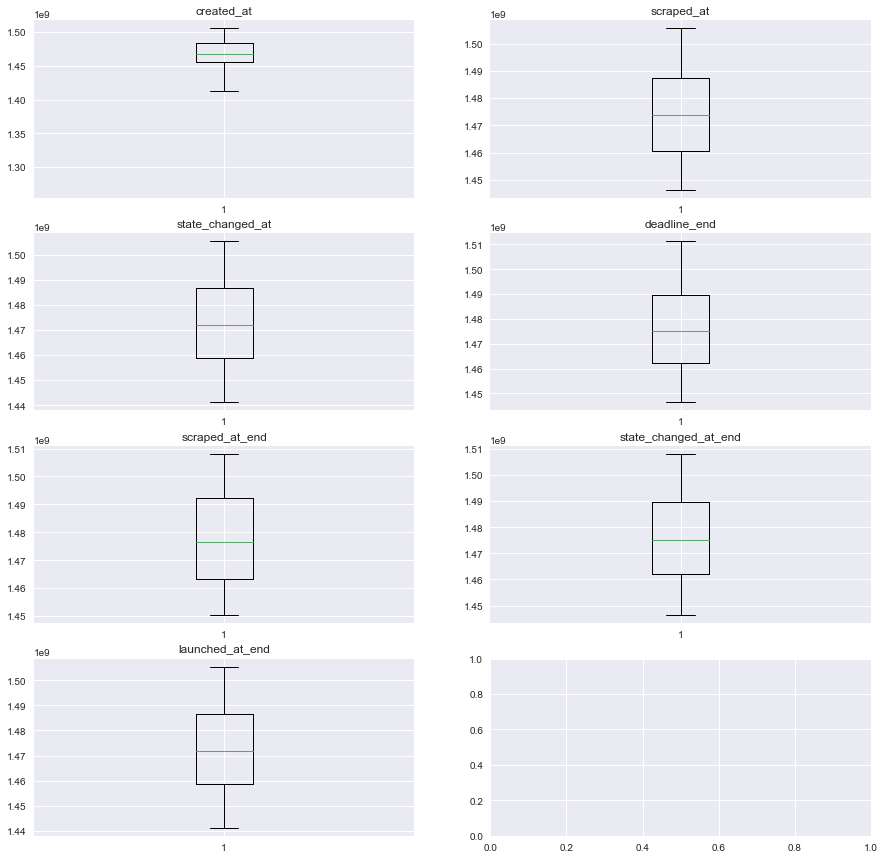

In [128]:
fig, ax = plt.subplots(nrows=4, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(7):
    plt.subplot(4, 2, i+1, title=selected_cols[i])
    plt.boxplot(df_projects[selected_cols[i]])

(1440000000.0, 1455000000.0)

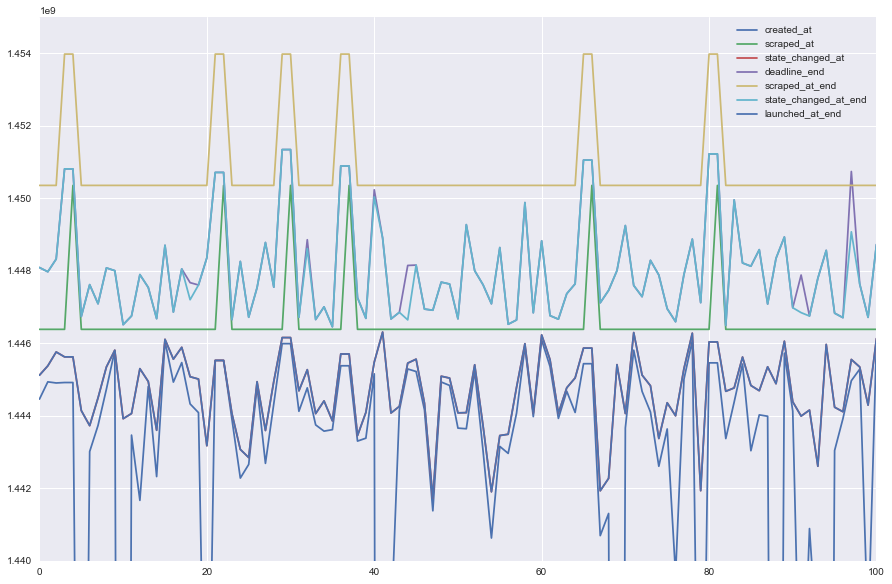

In [93]:
# head
df_projects.loc[:100,selected_cols].plot(figsize=(15,10))
axes = plt.gca()
axes.set_ylim([1.44e9, 1.455e9])

(1500000000.0, 1511000000.0)

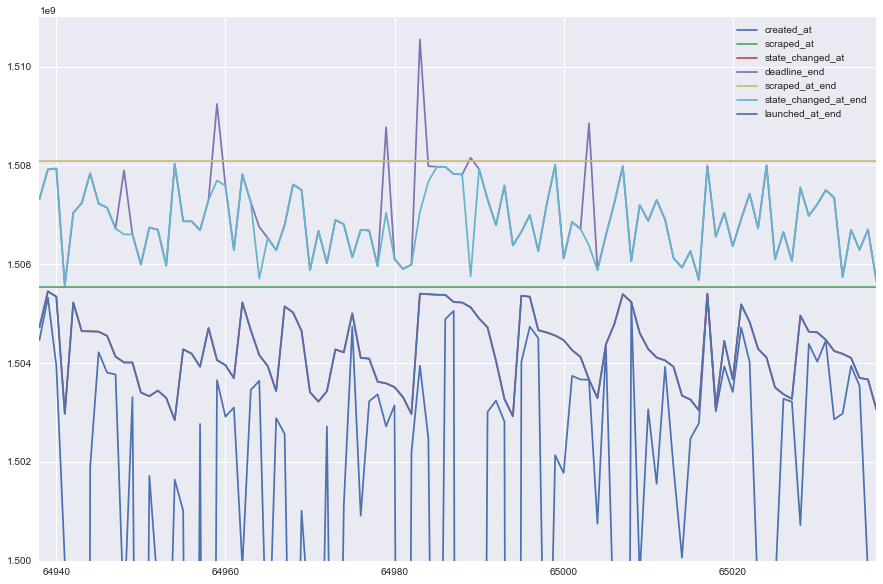

In [107]:
# tail
df_projects.loc[len(df_projects)-100:,selected_cols].plot(figsize=(15,10))
axes = plt.gca()
axes.set_ylim([1.5e9, 1.511e9])

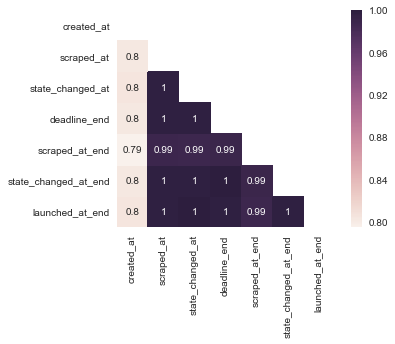

In [95]:
# correlations are high because timestamps are large numbers
print_corr_heatmap(selected_cols)

#### Converting timestamps (days between two events)

In [130]:
min_time = df_projects[selected_cols].min()
min_time.sort_values()

created_at              1.266343e+09
state_changed_at        1.441143e+09
launched_at_end         1.441143e+09
scraped_at              1.446387e+09
deadline_end            1.446392e+09
state_changed_at_end    1.446392e+09
scraped_at_end          1.450359e+09
dtype: float64

In [144]:
selected_cols[:]

['created_at',
 'launched_at_end',
 'state_changed_at',
 'deadline_end',
 'state_changed_at_end',
 'scraped_at',
 'scraped_at_end']

In [158]:
# reading by rows, every column says how many events occured before this event
l = ['col']
l.extend(selected_cols[:-2])
for col1 in selected_cols[:-2]:
    l.append(col1)
    for col2 in selected_cols[:-2]:
        l.append(len(df_projects[df_projects[col1] > df_projects[col2]]))
pd.DataFrame(np.array(l).reshape(6,6))

,0,1,2,3,4,5
0,col,created_at,launched_at_end,state_changed_at,deadline_end,state_changed_at_end
1,created_at,0,0,0,0,0
2,launched_at_end,65038,0,43,0,0
3,state_changed_at,65038,11949,0,0,0
4,deadline_end,65038,65038,65038,0,2501
5,state_changed_at_end,65038,65038,65038,24306,0


Most of the project events are following order:
1. created_at
2. launched_at_end
3. state_changed_at
4. deadline_end
5. state_changed_at_end

scraped_at and scraped_at_end were calculated using datetime of the original csv files provided by webrobots and therefore are not accurate

We can derive:
1. project_duration (deadline_end - launched_at_end)
2. pre_launch_duration (launched_at_end - created_at)
3. days_after_launch (scraped_at - launched_at_end)
4. days_before_deadline

In [ ]:
# diff scraped state changed

#### project_duration

In [188]:
df_projects['project_duration'] = df_projects.apply(lambda x: (datetime.fromtimestamp(x['deadline_end']) - datetime.fromtimestamp(x['launched_at_end'])).days, axis=1)

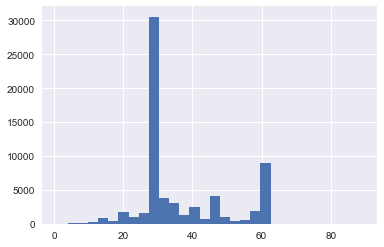

In [185]:
df_projects['project_duration'].hist(bins=30)

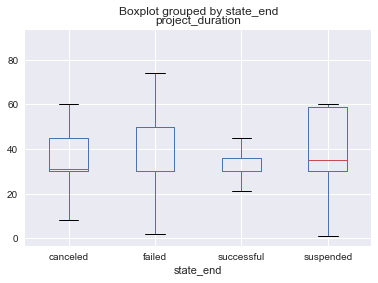

In [194]:
df_projects.boxplot(column='project_duration', by='state_end')

In [165]:
df_projects['project_duration'].min()

1

In [166]:
df_projects['project_duration'].max()

89

In [175]:
# nowadays maximum should be 60 days
# https://www.kickstarter.com/blog/shortening-the-maximum-project-length
# in past it was different (90?)
df_projects['project_duration'].value_counts().sort_index(ascending=False).head(10)

89       1
84       2
74       6
71       2
70       1
64       2
63       2
62       4
60    8943
59    1297
Name: project_duration, dtype: int64

#### pre_launch_duration

In [187]:
df_projects['pre_launch_duration'] = df_projects.apply(lambda x: (datetime.fromtimestamp(x['launched_at_end']) - datetime.fromtimestamp(x['created_at'])).days, axis=1)

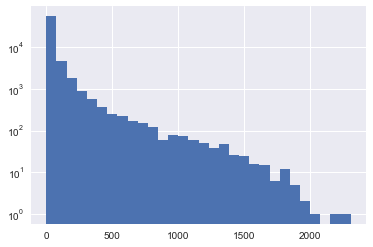

In [190]:
df_projects['pre_launch_duration'].hist(bins=30)
plt.yscale('log')

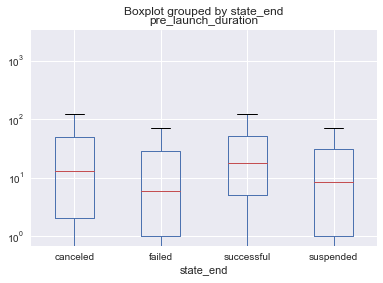

In [192]:
df_projects.boxplot(column='pre_launch_duration', by='state_end')
plt.yscale('log')

#### days_after_launch

In [195]:
df_projects['days_after_launch'] = df_projects.apply(lambda x: (datetime.fromtimestamp(x['scraped_at']) - datetime.fromtimestamp(x['launched_at_end'])).days, axis=1)

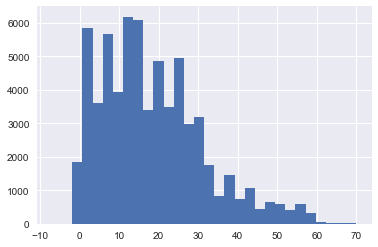

In [196]:
df_projects['days_after_launch'].hist(bins=30)

In [197]:
df_projects['days_after_launch'].min()

-7

In [198]:
df_projects['days_after_launch'].max()

70

In [201]:
df_projects['days_after_launch'].value_counts().sort_index().head(10)

-7       1
-1      26
 0    1834
 1    1955
 2    2108
 3    1784
 4    1746
 5    1855
 6    1789
 7    1815
Name: days_after_launch, dtype: int64

In [204]:
df_projects[df_projects['days_after_launch']<0][['blurb','launched_at_end','days_after_launch']]

,blurb,launched_at_end,days_after_launch
241,A psychedelic journey of coloring-in for adult...,1446388479,-1
249,Help me raise the funds to grow my company and...,1446389578,-1
639,Detroit Bikes is launching its most affordable...,1446391659,-1
795,"Fantini of Denmark is all about elegance, qual...",1446388804,-1
1028,Vertical Growth Inc. is working to open an ind...,1446391164,-1
1173,Sick(er) is a short film written and directed ...,1446389767,-1
1237,After a group of aspiring filmmakers encounter...,1446390555,-1
1891,A feature film about a 12-year-old being raise...,1446390365,-1
3788,An innovative and flexible web-filtering platf...,1446387612,-1
5306,Myself and Holly are going to Japan in April a...,1450359213,-1


## testing state_changed_at

In [205]:
df_projects['test'] = df_projects.apply(lambda x: (datetime.fromtimestamp(x['state_changed_at']) - datetime.fromtimestamp(x['launched_at_end'])).days, axis=1)

In [207]:
df_projects['test'].value_counts()

 0    64995
-1       40
-2        2
-9        1
Name: test, dtype: int64

In [214]:
df_projects[df_projects['test']<0][['name','state_changed_at','test']]

,name,state_changed_at,test
1883,the Dolphin Swim Club,1441357335,-1
2590,International Piano Competition & Festival for...,1445470228,-1
3898,Ozmo Smart Cup: Water Hydration & Coffee Enjoy...,1444147653,-1
9271,"Instant Hydrator, Hydrates,All Natural, Digest...",1453784664,-9
10853,3 Green Energy 3,1453832306,-1
11090,Cairn Project: using clay to address trauma,1457916773,-1
11807,The Doggie Lift - The Easiest Way to Cut Your ...,1458349583,-1
11808,The Doggie Lift - The Easiest Way to Cut Your ...,1458349583,-1
11859,Inslip® - A Comfortable Strap for ANY Phone an...,1454944244,-1
12599,Welcome to My World,1457117232,-1


https://www.kickstarter.com/projects/1428469449/instant-hydrator-hydratesall-natural-digestive-ph/updates
https://www.kickstarter.com/projects/1428469449/instant-hydrator-hydratesall-natural-digestive-ph/description

launched 26 Jan
vs
funding period 3 Feb

In [215]:
df_projects.drop('test', axis=1)

,backers_count,blurb,category,country,created_at,creator,currency,currency_trailing_code,goal,id,...,created_at_since_start,scraped_at_since_start,state_changed_at_since_start,deadline_end_since_start,scraped_at_end_since_start,state_changed_at_end_since_start,launched_at_end_since_start,project_duration,pre_launch_duration,days_after_launch
0,22,Help SCDT fund their inaugural performance in ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1444460998,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,True,8000.0,1857493693,...,178117756.0,180043702.0,178777910.0,181749498.0,184015566.0,181749498.0,178777910.0,34,7,14
1,0,This is where inspired dancers from all ages g...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",NL,1444938006,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",EUR,False,500.0,899273969,...,178594764.0,180043702.0,179036624.0,181632224.0,184015574.0,181632224.0,179036624.0,30,5,11
2,1,In our 8th year of equipping students to give ...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1444906983,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,True,25000.0,847102110,...,178563741.0,180043702.0,179419604.0,181983558.0,184015574.0,181983558.0,179419604.0,29,9,7
3,1,Verve Collisionz is a hip hop group at the Uni...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1444919408,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,True,600.0,1684830451,...,178576166.0,180043702.0,179283697.0,184471297.0,187638958.0,184471300.0,179283697.0,60,8,8
4,5,Verve Collisionz is a hip hop group at the Uni...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1444919408,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,True,600.0,1684830451,...,178576166.0,184015566.0,179283697.0,184471297.0,187638958.0,184471300.0,179283697.0,60,8,54
5,0,Very unique Social Standard of teaching dance!...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1420468528,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,True,25000.0,501585731,...,154125286.0,180043702.0,177801699.0,180397299.0,184015566.0,180397299.0,177801699.0,30,274,25
6,218,Finally we have a building but we need your he...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1443014021,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,True,8500.0,1899686686,...,176670779.0,180043702.0,177385533.0,181277133.0,184015566.0,181277134.0,177385533.0,45,8,30
7,4,Youtubers have vidcon and nerds have comiccon....,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1443735762,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,True,700000.0,498505629,...,177392520.0,180043702.0,178153194.0,180748794.0,184015574.0,180748798.0,178153194.0,30,8,21
8,61,The critically acclaimed festival of dance and...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1444738199,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,True,15000.0,163403488,...,178394957.0,180043702.0,179005699.0,181738698.0,184015566.0,181738698.0,179005699.0,31,7,11
9,15,Vacancy: A contemporary dance performance prod...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",US,1445806758,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,True,3200.0,148759962,...,179463516.0,180043702.0,179465743.0,181663158.0,184015566.0,181663158.0,179465743.0,25,0,6


# Second dataset

In [ ]:
import mysql.connector as sql

In [ ]:
con = sql.connect(database='kickstarter', user='kickstarter', password='kickstarter')

In [ ]:
df_db = pd.read_sql('SELECT * FROM kickstarter.kickstarter_project', con, index_col='project_id')
df_db.head()

In [ ]:
df_db.tail()

In [ ]:
df_db.info()

In [ ]:
# project_id is sequence but we could use url for merging with first dataset
df_db.loc[1, 'url']

In [ ]:
df_projects.loc[1, 'urls']

In [ ]:
import ast

In [ ]:
# get project_url
df_projects['project_url'] = df_projects.apply(lambda x: ast.literal_eval(x['urls'])['web']['project'].split('?')[0], axis=1)

In [ ]:
# merge first and second dataset
df_projects.info()

In [ ]:
df_merged = df_projects.merge(df_db, left_on='project_url', right_on='url')

In [ ]:
df_merged.info()

In [ ]:
df_merged.to_csv('merged.csv')

In [ ]:
x = df_projects[~df_projects['id'].isin(df_merged['id'])]
x.loc[380, 'project_url']

In [ ]:
x

In [ ]:
x = x.drop_duplicates(subset='id')
x

In [ ]:
x = x.drop_duplicates(subset='project_url')
x

In [ ]:
x['project_url'].value_counts().sort_values(ascending=False)

In [ ]:
x[x['id']==6186729].loc[14136, 'project_url']

In [ ]:
x[x['id']==6186729].loc[14137, 'project_url']

In [ ]:
x['project_url'].to_csv('urls.csv', index=False)

In [ ]:
pd.read_csv('urls.txt')

In [ ]:
df_projects['state']